In [3]:
import pandas as pd

# Cargar dataset procesado
df = pd.read_csv("../data/processed/llamadas_diarias.csv", parse_dates=["date"])

# Solo últimos 30 días del histórico (abril 2025)
max_fecha = df["date"].max()
fecha_split = max_fecha - pd.Timedelta(days=30)
df_test = df[df["date"] >= fecha_split].copy()

# Mostrar estructura para confirmar
print("✅ Datos cargados correctamente")
print(df_test.head())
print("\nIdiomas disponibles:", df_test["idioma"].unique())
print("Clientes disponibles:", df_test["cliente"].unique())


✅ Datos cargados correctamente
          date cliente idioma  y  dayofweek  is_month_end  lag_1  lag_2  \
263 2025-03-31  AIRBNB     DE  7          0             1    3.0    9.0   
264 2025-04-01  AIRBNB     DE  6          1             0    7.0    3.0   
265 2025-04-02  AIRBNB     DE  5          2             0    6.0    7.0   
266 2025-04-03  AIRBNB     DE  7          3             0    5.0    6.0   
267 2025-04-04  AIRBNB     DE  4          4             0    7.0    5.0   

     lag_3  lag_4  lag_5  
263   10.0   11.0    4.0  
264    9.0   10.0   11.0  
265    3.0    9.0   10.0  
266    7.0    3.0    9.0  
267    6.0    7.0    3.0  

Idiomas disponibles: ['DE' 'EN' 'ES' 'FR' 'IT' 'NL' 'PT' 'FI' 'NO' 'Other' 'PO' 'SE' 'DK']
Clientes disponibles: ['AIRBNB' 'AMEX' 'COLUMBUS']


C:\Users\gcasc\AppData\Local\Temp\ipykernel_16992\3185507211.py:45: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\gcasc\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


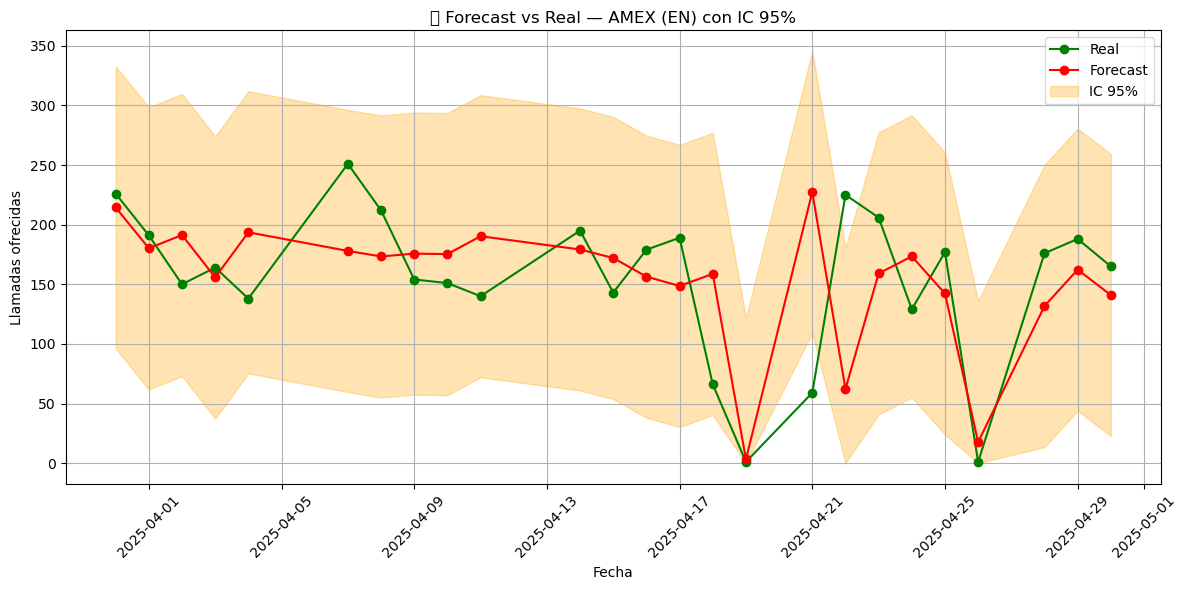

In [7]:
import matplotlib.pyplot as plt
import joblib
from pathlib import Path
import numpy as np

# Parámetros
cliente = "AMEX"
idioma = "EN"

# Cargar modelo
modelo_path = Path().resolve().parent / "notebooks" / "models" / f"xgb_{cliente}_{idioma}.pkl"
modelo = joblib.load(modelo_path)

# Filtrar datos
df_idioma = df_test[(df_test["cliente"] == cliente) & (df_test["idioma"] == idioma)].copy()
feature_cols = ["dayofweek", "is_month_end", "lag_1", "lag_2", "lag_3", "lag_4", "lag_5"]

# Predicción
X = df_idioma[feature_cols]
y = df_idioma["y"]
y_pred = modelo.predict(X)

# Calcular RMSE e IC
rmse = np.sqrt(np.mean((y - y_pred)**2))
ic_upper = y_pred + 1.96 * rmse
ic_lower = y_pred - 1.96 * rmse

# Aplicar piso 0
df_idioma["y_pred"] = np.clip(y_pred, 0, None)
df_idioma["ic_upper"] = np.clip(ic_upper, 0, None)
df_idioma["ic_lower"] = np.clip(ic_lower, 0, None)

# Gráfico
plt.figure(figsize=(12, 6))
plt.plot(df_idioma["date"], y, label="Real", marker='o', color="green")
plt.plot(df_idioma["date"], df_idioma["y_pred"], label="Forecast", marker='o', color="red")
plt.fill_between(df_idioma["date"], df_idioma["ic_lower"], df_idioma["ic_upper"],
                 color="orange", alpha=0.3, label="IC 95%")
plt.title(f"📈 Forecast vs Real — {cliente} ({idioma}) con IC 95%")
plt.xlabel("Fecha")
plt.ylabel("Llamadas ofrecidas")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

